# 8. [Gradient Descent 梯度遞減](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/gradient_descent.py)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
from collections import Counter
from linear_algebra import distance, vector_subtract, scalar_multiply
import math, random

In [3]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

a = [1, 2]
sum_of_squares(a)

5

In [5]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

def f(x):
    return x**2

difference_quotient(f, 3, 0.001)

6.000999999999479

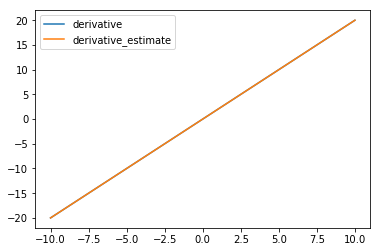

In [6]:
def plot_estimated_derivative(h=0.00001):

    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=h)

    # plot to show they're basically the same
#     import matplotlib.pyplot as plt
    x = np.linspace(-10, 10, 100)
    plt.plot(x, list(map(derivative, x)), label = 'derivative')           # red  x
    plt.plot(x, list(map(derivative_estimate, x)), label = 'derivative_estimate')  # blue +
    plt.legend()
    plt.show()                                      # purple *, hopefully
    
plot_estimated_derivative()    

In [9]:
def partial_difference_quotient(f, v, i, h):
    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]         
    return (f(w) - f(v)) / h

a = [1, 2]
partial_difference_quotient(sum_of_squares, a, 1, 0.001)  # a 點 在 分量 1 上的 difference quotient, 函數是 sum_of_squares

4.000999999999699

In [11]:
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)] 

a = [1, 2]
estimate_gradient(sum_of_squares, a, 0.001)  # sum_of_squares 在點 a 位置上的偏微分 gradients

[2.0009999999999195, 4.000999999999699]

In [13]:
def sum_of_squares_gradient(v): 
    return [2 * v_i for v_i in v]

sum_of_squares_gradient(a)

[2, 4]

In [31]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

a = [1, 2]
gradient = estimate_gradient(sum_of_squares, a, 0.001)
step(a, gradient, -0.01)

# for _ in range(10000):
#     gradient = estimate_gradient(sum_of_squares, a, 0.001)
#     a = step(a, gradient, -0.01)    
# a

[0.9799900000000008, 1.959990000000003]

In [14]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

In [15]:
#
# 
# minimize / maximize batch
#
#

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing
    
    while True:
        gradient = gradient_fn(theta)  
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
                   
        # choose the one that minimizes the error function        
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        
        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

In [18]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs) 

In [19]:
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

In [20]:
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0, 
                          tolerance)

In [21]:
#
# minimize / maximize stochastic
#

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

In [38]:
# x, y 中的每一對元素，和 theta 經過運算，求能使 target_fn(x_i, y_i, theta) 得到最小值的 theta

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = zip(x, y)
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0
    
    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)  # 將每個資料點所預測的誤差累加起來，作為整組資料誤差的預測值

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        # 
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)  # 求特定資料點上的 gradient
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))  # 調整 theta
            
    return min_theta

In [39]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

In [41]:
if __name__ == "__main__":

    print("using the gradient")

    v = [random.randint(-10,10) for i in range(3)]

    tolerance = 0.0000001

    while True:
        #print(v, sum_of_squares(v)
        gradient = sum_of_squares_gradient(v)   # compute the gradient at v
        next_v = step(v, gradient, -0.01)       # take a negative gradient step
        if distance(next_v, v) < tolerance:     # stop if we're converging
            break
        v = next_v                              # continue if we're not

    print("minimum v", v)
    print("minimum value", sum_of_squares(v))
    print()
 
    
    print("using minimize_batch") 

    v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)  # 使用 minimize_batch 求最小值

    print("minimum v", v)
    print("minimum value", sum_of_squares(v))    
 
    
#     print("using minimize_stochastic") 

#     v = minimize_stochastic(sum_of_squares, sum_of_squares_gradient, v)  # 使用 minimize_stochastic 求最小值

#     print("minimum v", v)
#     print("minimum value", sum_of_squares(v))

using the gradient
minimum v [4.163601529674763e-06, -1.8504895687443374e-06, -1.8504895687443374e-06]
minimum value 2.418420098597323e-11

using minimize_batch
minimum v [4.163601529674763e-06, -1.8504895687443374e-06, -1.8504895687443374e-06]
minimum value 2.418420098597323e-11
